# Experimental Notebook
- Task: train a model for segment one of the seismic facies (the model learn about borders, so the user need send prompts for the model learn where apply segmentation)

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
from typing import List, Optional, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap

import lightning as L
import torch
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from torchinfo import summary
from torch import nn

from minerva.models.finetune_adapters import LoRA
from minerva.models.nets.image.sam import Sam
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline

from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from lightning.pytorch.loggers import CSVLogger

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


## Variables

In [3]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# parihaka
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoints SAM
checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth" # vit_b
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_h_4b8939.pth" # vit_h

model_name = "SAM-ViT_B_with_prompts"
vit_model = 'vit-b'
height, width = 255, 701 # f3
# height, width = 1006, 590 # parihaka
multimask_output=False # if true, segment num_classes
num_classes = 3
num_points = 3
num_epochs = 15
batch_size = 2

## Transform

In [4]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded

## Custom Dataset for SAM
- have prompts implemented

In [30]:
class DatasetForSAM(SimpleDataset):
    def __init__(
            self, 
            readers: List[_Reader], 
            transforms: Optional[_Transform] = None,
            num_points:int=3
    ):
        super().__init__(readers, transforms)

        assert (
            len(self.readers) == 2
        ), "DatasetForSAM requires exactly 2 readers (image your label)"

        self.num_points = num_points
        self.samples = []
        self._preprocess_data()
    
    def _preprocess_data(self):
        for index in range(len(self.readers[0])):
            data_readers = []
            for reader, transform in zip(self.readers, self.transforms):
                sample = reader[index]
                if transform is not None:
                    sample = transform(sample)
                data_readers.append(sample)
            
            image = data_readers[0]
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            image = (image * 255).clamp(0, 255).to(torch.uint8)
            label = data_readers[1]
            
            num_facies = np.unique(label)
            
            for facie in num_facies:
                region = np.zeros_like(label, dtype=np.uint8) # [H,W]
                region[label == facie] = 1

                point_coords = self.get_points_in_region(region=region, num_points=self.num_points)
                self.samples.append((image, region, point_coords))

    def get_points_in_region(self, region, num_points=3):
        # # Garantir que a região tem apenas valores 0 e 1
        # region = (region > 0).astype(np.uint8)

        # Garantir que a matriz tem apenas duas dimensões removendo a dimensão extra
        if region.ndim == 3 and region.shape[0] == 1:
            region = region.squeeze(0)  # Remove a primeira dimensão (1, H, W) -> (H, W)


        # Verificar se a região contém apenas valores 0 e 1
        unique_values = np.unique(region)
        if not np.array_equal(unique_values, [0, 1]) and not np.array_equal(unique_values, [1]) and not np.array_equal(unique_values, [0]):
            raise ValueError(f"A matriz 'region' contém valores inesperados: {unique_values}. Esperado apenas 0 e 1.")

        # Obter todas as coordenadas (y, x) da região branca
        y_indices, x_indices = np.where(region == 1)

        # Se não houver pontos na região, retornar uma lista vazia
        if len(y_indices) == 0:
            return []

        # Encontrar o centro vertical de cada coluna
        unique_x = np.unique(x_indices)
        central_y_coords = []

        for x in unique_x:
            y_in_column = y_indices[x_indices == x]

            if len(y_in_column) > 0:
                central_y = y_in_column[len(y_in_column) // 2]  # Pega um ponto real, não a média
                central_y_coords.append((x, central_y))

        # Ordenar os pontos pela coordenada x
        central_y_coords = sorted(central_y_coords, key=lambda coord: coord[0])

        # Selecionar pontos equidistantes
        num_points = min(num_points, len(central_y_coords))
        indices = np.linspace(0, len(central_y_coords) - 1, num_points, dtype=int)
        
        selected_points = [central_y_coords[i] for i in indices]

        # Filtrar pontos que realmente pertencem à região branca
        filtered_points = [(int(x), int(round(y)), 1) for x, y in selected_points if region[int(round(y)), int(x)] == 1]

        return filtered_points
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        index: Tuple:
            - (image, label, point_coords)
        """
        image, label, point_coords = self.samples[index]
        
        # preparing points and labels for add with prompt to SAM
        points = [[x, y] for (x, y, value) in point_coords]
        labels = [1] * len(points)

        # image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        original_size = (int(image.shape[1]), int(image.shape[2])) # torch.tensor((int(image.shape[1]), int(image.shape[2])), dtype=torch.long)

        # Verificar se original_size é uma tupla com 2 elementos
        if not isinstance(original_size, tuple) or len(original_size) != 2:
            raise ValueError(f"original_size is not a valid tuple: {original_size}")

        points = torch.tensor(points, dtype=torch.long).unsqueeze(0)  # Adicionando uma dimensão no início
        labels = torch.tensor(labels, dtype=torch.long).unsqueeze(0)  # Adicionando uma dimensão no início
        
        data = {
            'image': image,
            'label': label,
            'original_size': original_size,
            'point_coords': points,
            'point_labels': labels
        }

        return data

## Data Module

In [31]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        num_points:int = 3,
        batch_size: int = 1,
        data_ratio: float = 1.0,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.num_points = num_points
        self.batch_size = batch_size
        self.data_ratio = data_ratio
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")

            # applying ratio
            num_train_samples = int(len(train_img_reader) * self.data_ratio)
            if num_train_samples < len(train_img_reader):
                indices = random.sample(range(len(train_img_reader)), num_train_samples)
                train_img_reader = [train_img_reader[i] for i in indices]
                train_label_reader = [train_label_reader[i] for i in indices]
                
            train_dataset = DatasetForSAM(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                num_points=self.num_points
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = DatasetForSAM(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                num_points=self.num_points
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = DatasetForSAM(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                num_points=self.num_points
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")
    
    def custom_collate_fn(self, batch):
        """
        Custom collate function for DataLoader to return a list of dictionaries.
        """
        return batch 

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self.custom_collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

## Init data module

In [32]:
data_module = DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=Padding(height, width),
    batch_size=batch_size,
    num_points=num_points
)

### Test data module

In [33]:
def get_train_dataloader(data_module):
    data_module.setup("fit")
    return data_module.train_dataloader()

test_train_dataloader = get_train_dataloader(data_module)
print("Total batches: ", len(test_train_dataloader))

Total batches:  2557


In [34]:
train_batch = next(iter(test_train_dataloader))
print(f"Train batch image (X) shape: {train_batch[0]['image'].shape} - type: {type(train_batch[0]['image'])}")
print(f"Train batch label (Y) shape: {train_batch[0]['label'].shape} - type: {type(train_batch[0]['label'])}")
print(f"Train batch label (original_size) shape: {train_batch[0]['original_size']} - type: {type(train_batch[0]['original_size'])}")
print(f"Train batch point_coords shape: {train_batch[0]['point_coords'].shape} - type: {type(train_batch[0]['point_coords'])}")
print(f"Train batch point_labels shape: {train_batch[0]['point_labels'].shape} - type: {type(train_batch[0]['point_labels'])}")

Train batch image (X) shape: torch.Size([3, 255, 701]) - type: <class 'torch.Tensor'>
Train batch label (Y) shape: torch.Size([1, 255, 701]) - type: <class 'torch.Tensor'>
Train batch label (original_size) shape: (255, 701) - type: <class 'tuple'>
Train batch point_coords shape: torch.Size([1, 3, 2]) - type: <class 'torch.Tensor'>
Train batch point_labels shape: torch.Size([1, 3]) - type: <class 'torch.Tensor'>


In [35]:
print(f"O Batch (de tamanho {len(train_batch)}) possui: {train_batch[0]['image'].shape[0]} canais, {train_batch[0]['image'].shape[1]} altura e {train_batch[0]['image'].shape[2]} largura.")

O Batch (de tamanho 2) possui: 3 canais, 255 altura e 701 largura.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape da image:  torch.Size([3, 255, 701])
intervalo da image:  tensor(-1.) tensor(1.)
shape da label:  torch.Size([1, 255, 701])
tensor([[[  0,  86],
         [350,  99],
         [700, 103]]])


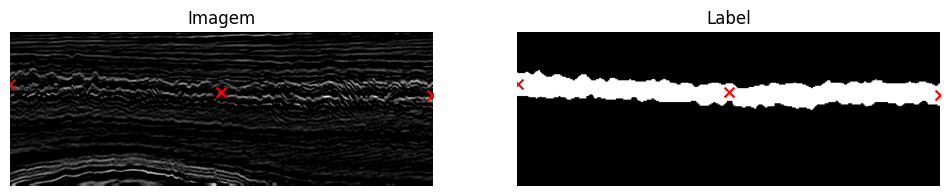

In [36]:
train_batch = next(iter(test_train_dataloader))

# Obtendo a imagem e a label do batch
print("shape da image: ", train_batch[0]['image'].shape)
print("intervalo da image: ", torch.min(train_batch[0]['image']), torch.max(train_batch[0]['image']))
print("shape da label: ", train_batch[0]['label'].shape)
# image = train_batch[0]['image'].squeeze(0)  # Remover a dimensão do batch (1, 3, 1006, 590) -> (3, 1006, 590)
# label = train_batch[0]['label'].squeeze(0)  # Remover a dimensão do batch (1, 1, 1006, 590) -> (1, 1006, 590)

# Transformando para formato adequado para matplotlib
points = train_batch[0]['point_coords'] # Lista de coordenadas (x, y)
print(points)
image = train_batch[0]['image'].permute(1, 2, 0).cpu().numpy()  # (3, 1006, 590) -> (1006, 590, 3)
label = train_batch[0]['label'].squeeze(0)  # (1, 1006, 590) -> (1006, 590)

# Plotando a imagem e a label
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original
axes[0].imshow(image)
axes[0].set_title("Imagem")
axes[0].axis('off')

# Plotando os pontos na imagem
for point in points:
    for y, x in point:
        axes[0].scatter(y, x, color='red', s=50, marker='x', label='Ponto')

# Label (provavelmente uma máscara ou rótulo binário)
axes[1].imshow(label, cmap='gray')
axes[1].set_title("Label")
axes[1].axis('off')

# plotando os pontos na label
for point in points:
    for y, x in point:
        axes[1].scatter(y, x, color='red', s=50, marker='x', label='Ponto')

plt.show()

## Init model

In [12]:
model = Sam(
    vit_type=vit_model,
    checkpoint=checkpoint_path,
    num_multimask_outputs=num_classes, # default: 3
    iou_head_depth=num_classes, # default: 3
    apply_freeze={"image_encoder": False, "prompt_encoder": False, "mask_decoder": False},
    # apply_adapter=apply_adapter,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    # multimask_output=multimask_output,
    # loss_fn=DiceCELoss() # if multimask_output is false
)

model

/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/sam.py:2343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (loss_fn): CrossEntropyLoss()
  (model): _SAM(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256,

In [13]:
def calculate_model_size(model: torch.nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = total_params * 4  # 4 bytes por parâmetro
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb

print("Peso em MB: ", calculate_model_size(model))
summary(model)

Peso em MB:  357.57244873046875


Layer (type:depth-idx)                                       Param #
Sam                                                          --
├─CrossEntropyLoss: 1-1                                      --
├─_SAM: 1-2                                                  --
│    └─ImageEncoderViT: 2-1                                  3,145,728
│    │    └─PatchEmbed: 3-1                                  590,592
│    │    └─ModuleList: 3-2                                  85,147,136
│    │    └─Sequential: 3-3                                  787,456
│    └─PromptEncoder: 2-2                                    --
│    │    └─PositionEmbeddingRandom: 3-4                     --
│    │    └─ModuleList: 3-5                                  1,024
│    │    └─Embedding: 3-6                                   256
│    │    └─Sequential: 3-7                                  4,684
│    │    └─Embedding: 3-8                                   256
│    └─MaskDecoder: 2-3                                      --
│ 

## Train

In [14]:
current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    # monitor="val_loss", # Métrica para monitorar
    save_last=True,
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"sam-{model_name}-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    # save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    # mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

logger = CSVLogger("logs", name="sam")

trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/seed.py:42: No seed found, seed set to 0
Seed set to 0


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


/usr/local/lib/python3.10/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/sam/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | _SAM             | 93.7 M | train
-----------------------------------------------------
93.7 M    Trainable params
0         Non-trainable params
93.7 M    Total params
374.942   Total estimated model params size (MB)
239       Modules in train mode
0         Modules in eval mode


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 14: 100%|██████████| 2557/2557 [13:28<00:00,  3.16it/s, v_num=0, train_loss_step=0.000395, train_mIoU_step=0.983, val_loss_step=0.00137, val_mIoU_step=0.991, val_loss_epoch=0.00526, val_mIoU_epoch=0.990, train_loss_epoch=0.00444, train_mIoU_epoch=0.991]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 2557/2557 [13:35<00:00,  3.14it/s, v_num=0, train_loss_step=0.000395, train_mIoU_step=0.983, val_loss_step=0.00137, val_mIoU_step=0.991, val_loss_epoch=0.00526, val_mIoU_epoch=0.990, train_loss_epoch=0.00444, train_mIoU_epoch=0.991]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


## Test

In [15]:
pipeline.run(data=data_module, task="test")

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1138/1138 [02:06<00:00,  9.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.10471148043870926    │
│      test_mIoU_epoch      │    0.9132229089736938     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


[{'test_loss_epoch': 0.10471148043870926,
  'test_mIoU_epoch': 0.9132229089736938}]

## Predict

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   3%|▎         | 38/1138 [00:04<02:02,  8.94it/s]

Predicting DataLoader 0: 100%|██████████| 1138/1138 [02:06<00:00,  9.00it/s]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_0/run_2025-01-21-23-36-35f23fc62342ae4d87a66671195d7a2c14.yaml


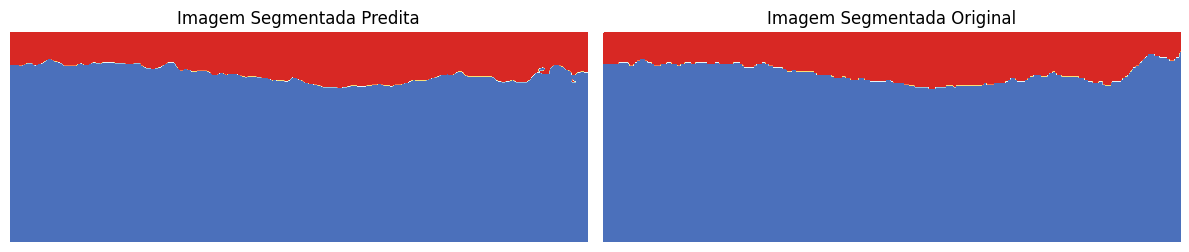

In [16]:
# Definir o cmap para a imagem segmentada
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

# Criar o subplot com duas colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primeira imagem - Predição original
preds = pipeline.run(data=data_module, task="predict")
image1 = torch.argmax(preds[108][0]['masks_logits'], dim=1)
axes[0].imshow(image1.squeeze().numpy(), cmap=label_cmap)
axes[0].set_title("Imagem Segmentada Predita")
axes[0].axis("off")

# Segunda imagem - Predição com DataLoader
data_module.setup("predict")
pred_module = iter(data_module.predict_dataloader())

# Iterando para pegar o 108º elemento
for i, batch in enumerate(pred_module):
    if i == 108:
        pred_108 = batch  # Pega o batch de predição
        break

# Segunda imagem - Máscara segmentada da predição
image2 = pred_108[0]['label']
axes[1].imshow(image2.squeeze().numpy(), cmap=label_cmap)
axes[1].set_title("Imagem Segmentada Original")
axes[1].axis("off")

plt.tight_layout()
plt.show()